In [1]:
!pip freeze | grep scikit-learn

scikit-learn==1.1.1


In [2]:
import pickle
import pandas as pd

In [3]:
with open('model.bin', 'rb') as f_in:
    dv, lr = pickle.load(f_in)

In [4]:
categorical = ['PUlocationID', 'DOlocationID']

def read_data(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df

In [5]:
df = read_data('https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet')

In [6]:
dicts = df[categorical].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = lr.predict(X_val)

### Q1. Notebook

We'll start with the same notebook we ended up with in homework 1.

We cleaned it a little bit and kept only the scoring part. Now it's in homework/starter.ipynb.

Run this notebook for the February 2021 FVH data.

What's the mean predicted duration for this dataset?

    11.19
    16.19
    21.19
    26.19


In [7]:
y_pred.mean()

16.191691679979066

### Q2. Preparing the output

In [8]:
year = 2021
month = 2
df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')
df['ride_duration'] = y_pred
df_result = df[['ride_id', 'ride_duration']]
df_result

,ride_id,ride_duration
1,2021/02_1,14.539865
2,2021/02_2,13.740422
3,2021/02_3,15.593339
4,2021/02_4,15.188118
5,2021/02_5,13.817206
...,...,...
1037687,2021/02_1037687,12.433246
1037688,2021/02_1037688,12.910885
1037689,2021/02_1037689,15.834923
1037690,2021/02_1037690,16.783176


In [9]:
output_file = 'result_202102.parquet'

df_result.to_parquet(
    output_file,
    engine='pyarrow',
    compression=None,
    index=False
)

In [10]:
!du -h result_202102.parquet

19M	result_202102.parquet


### Q3. Creating the scoring script

Now let's turn the notebook into a script.

Which command you need to execute for that?

In [11]:
!jupyter nbconvert --to script starter.ipynb

[NbConvertApp] Converting notebook starter.ipynb to script
[NbConvertApp] Writing 2650 bytes to starter.py


### Q4. Virtual environment

Now let's put everything into a virtual environment. We'll use pipenv for that.

Install all the required libraries. Pay attention to the Scikit-Learn version: check the starter notebook for details.

After installing the libraries, pipenv creates two files: Pipfile and Pipfile.lock. The Pipfile.lock file keeps the hashes of the dependencies we use for the virtual env.

What's the first hash for the Scikit-Learn dependency?

In [12]:
import sklearn
sklearn.__version__

'1.0.2'

In [16]:
!pipenv install scikit-learn==1.0.2 pyarrow pandas --python==3.9

Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.
Installing scikit-learn==1.0.2...
Adding scikit-learn to Pipfile's [packages]...
✔ Installation Succeeded 
Installing pyarrow...
Adding pyarrow to Pipfile's [packages]...
✔ Installation Succeeded 
Installing pandas...
Adding pandas to Pipfile's [packages]...
✔ Installation Succeeded 
Pipfile.lock (c1d6ab) out of date, updating to (4076db)...
Locking [dev-packages] dependencies...
Locking [packages] dependencies...
Building requirements...
Resolving dependencies...
✔ Success! 
Updated Pipfile.lock (4076db)!
Installing dependencies from Pipfile.lock (4076db)...
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 0/0 — 00:00:00
To activate this project's virtualenv, run p

In [17]:
!cat Pipfile.lock

{
    "_meta": {
        "hash": {
            "sha256": "2fbb713c5e231cbad2b86f0ae9ecd6ce680c7054c8b3b88ad20f7315224076db"
        },
        "pipfile-spec": 6,
        "requires": {
            "python_version": "3.9"
        },
        "sources": [
            {
                "name": "pypi",
                "url": "https://pypi.org/simple",
                "verify_ssl": true
            }
        ]
    },
    "default": {
        "joblib": {
            "hashes": [
                "sha256:4158fcecd13733f8be669be0683b96ebdbbd38d23559f54dca7205aea1bf1e35",
                "sha256:f21f109b3c7ff9d95f8387f752d0d9c34a02aa2f7060c2135f465da0e5160ff6"
            ],
            "markers": "python_version >= '3.6'",
            "version": "==1.1.0"
        },
        "numpy": {
            "hashes": [
                "sha256:0791fbd1e43bf74b3502133207e378901272f3c156c4df4954cad833b1380207",
                "sha256:1ce7ab2053e36c0a71e7a13a7475bd3b1f54750b4b433adc96313e127b870887",
          

### Q5. Parametrize the script

Let's now make the script configurable via CLI. We'll create two parameters: year and month.

Run the script for March 2021.

What's the mean predicted duration?

    11.29
    16.29
    21.29
    26.29

Hint: just add a print statement to your script.

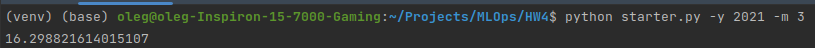

### Q6. Docker contaner

Finally, we'll package the script in the docker container. For that, you'll need to use a base image that we prepared.

This is how it looks like:

FROM python:3.9.7-slim

WORKDIR /app
COPY [ "model2.bin", "model.bin" ]

(see homework/Dockerfile)

We pushed it to agrigorev/zoomcamp-model:mlops-3.9.7-slim, which you should use as your base image.

That is, this is how your Dockerfile should start:

FROM agrigorev/zoomcamp-model:mlops-3.9.7-slim

\# do stuff here

This image already has a pickle file with a dictionary vectorizer and a model. You will need to use them.

Important: don't copy the model to the docker image. You will need to use the pickle file already in the image.

Now run the script with docker. What's the mean predicted duration for April 2021?

    9.96
    16.55
    25.96
    36.55


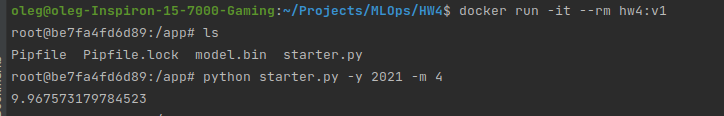